## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [5]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [6]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [8]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [9]:
# save the data set

data.to_csv('titanic.csv', index=False)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


## Data Exploration

### Find numerical and categorical variables

In [10]:
target = 'survived'

In [11]:
vars_num = ['pclass', 'age', 'sibsp', 'parch', 'fare']


vars_cat = ['sex', 'cabin', 'embarked', 'title']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables
data[vars_num].isnull().sum()


pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64

In [13]:
# now in categorical variables
data[vars_cat].isnull().sum()


sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine cardinality of categorical variables

In [15]:
for var in vars_cat:
    print(var, data[var].nunique())


sex 2
cabin 181
embarked 3
title 5


### Determine the distribution of numerical variables

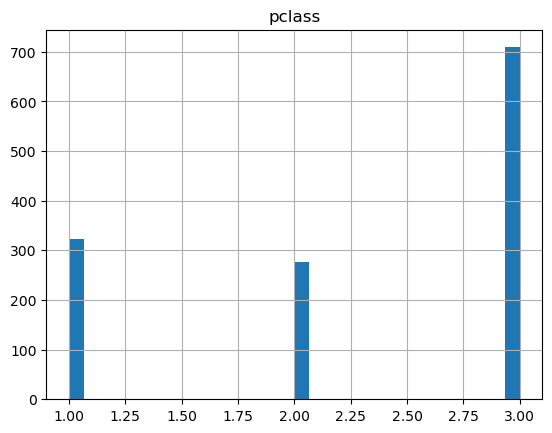

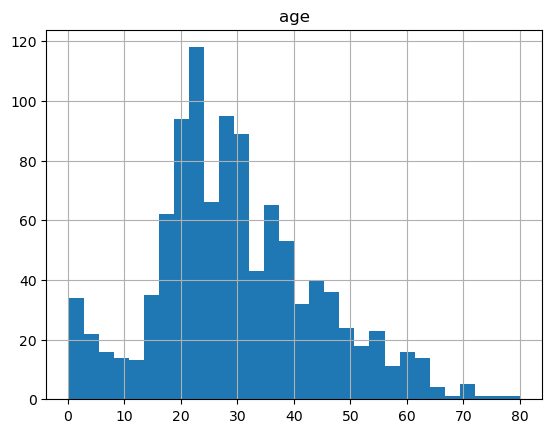

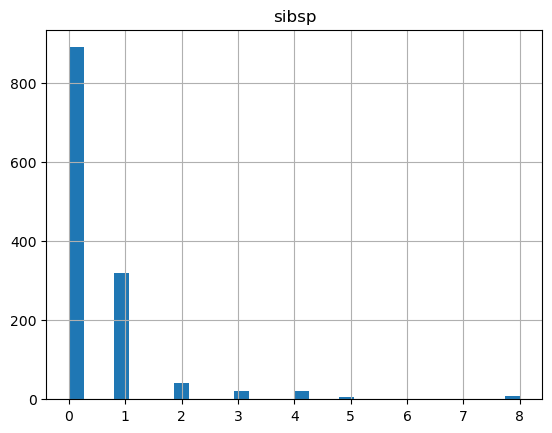

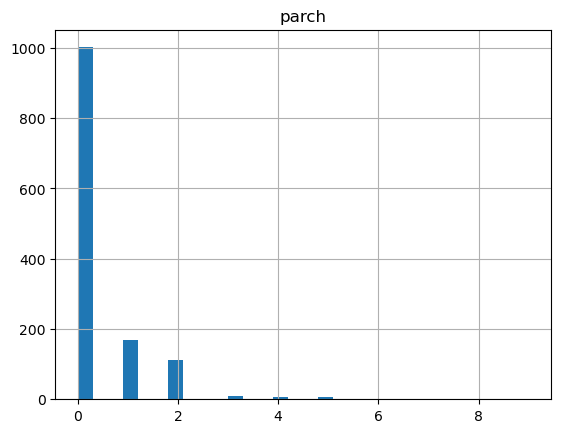

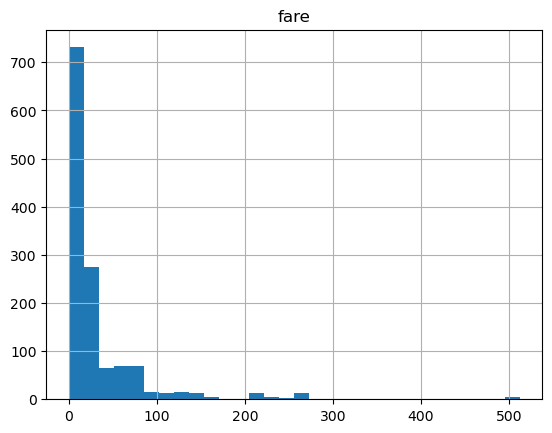

In [16]:
for var in vars_num:
    plt.figure()
    data[var].hist(bins=30)
    plt.title(var)
    plt.show()


## Distribution of Numerical Variables

pclass: A discrete variable with three possible values (1, 2, 3). Most passengers belong to the 3rd class.

age: Approximately unimodal distribution with slight right skewness. Most passengers are between 20 and 40 years old.

sibsp and parch: Highly skewed distributions, with most passengers having a value of 0 (traveling alone).

fare: Strongly right-skewed distribution with several extreme values (outliers). This suggests that a transformation (e.g., log transformation) may help reduce skewness and improve model performance.

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [18]:
# extracting only first letter from cabin

X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]


In [23]:
X_train['cabin'].nunique()


8

In [24]:
X_test['cabin'].nunique()

7

In [25]:
# check how many unique cabin categories we have in the training set
print("Number of unique cabin categories in X_train:",
      X_train['cabin'].nunique())

# check how many unique cabin categories we have in the test set
print("Number of unique cabin categories in X_test:",
      X_test['cabin'].nunique())

# display the actual unique categories in the training set
print("\nUnique cabin categories in X_train:")
print(sorted(X_train['cabin'].dropna().unique()))

# display the actual unique categories in the test set
print("\nUnique cabin categories in X_test:")
print(sorted(X_test['cabin'].dropna().unique()))


Number of unique cabin categories in X_train: 8
Number of unique cabin categories in X_test: 7

Unique cabin categories in X_train:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

Unique cabin categories in X_test:
['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [26]:
# Note:
# The cabin category 'T' appears in the training set but not in the test set. (what to do?)
# The model may encounter categories during training that are not present in the test data.


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [27]:
# numerical variables with missing values
vars_num_with_na = [var for var in vars_num if X_train[var].isnull().sum() > 0]

# add binary missing indicators (1 if missing, 0 otherwise)
for var in vars_num_with_na:
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)

# Filling NA missing values with the median (median computed on training set)
for var in vars_num_with_na:
    median_val = X_train[var].median()
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)


In [28]:
X_train[vars_num_with_na].isnull().sum(), X_test[vars_num_with_na].isnull().sum()


(age     0
 fare    0
 dtype: int64,
 age     0
 fare    0
 dtype: int64)

### Replace Missing data in categorical variables with the string **Missing**

In [29]:
# categorical variables with missing values
vars_cat_with_na = [var for var in vars_cat if X_train[var].isnull().sum() > 0]

In [30]:
# replace missing values with the string 'Missing'
for var in vars_cat_with_na:
    X_train[var] = X_train[var].fillna('Missing')
    X_test[var] = X_test[var].fillna('Missing')

In [31]:
# check that there are no missing values left
X_train[vars_cat_with_na].isnull().sum(), X_test[vars_cat_with_na].isnull().sum()

(cabin       0
 embarked    0
 dtype: int64,
 cabin       0
 embarked    0
 dtype: int64)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [32]:
# define the minimum frequency threshold
rare_perc = 0.05


In [33]:
for var in vars_cat:
    
    # get frequency of each category in training set
    freq = X_train[var].value_counts(normalize=True)
    
    # find categories that appear in less than 5% of observations
    rare_labels = freq[freq < rare_perc].index
    
    # replace rare labels with 'Rare'
    X_train[var] = np.where(X_train[var].isin(rare_labels), 'Rare', X_train[var])
    X_test[var] = np.where(X_test[var].isin(rare_labels), 'Rare', X_test[var])


In [34]:
for var in vars_cat:
    print(var)
    print(X_train[var].value_counts(normalize=True))
    print('-------------------------')


sex
sex
male      0.633238
female    0.366762
Name: proportion, dtype: float64
-------------------------
cabin
cabin
Missing    0.766953
Rare       0.158548
C          0.074499
Name: proportion, dtype: float64
-------------------------
embarked
embarked
S       0.709647
C       0.195798
Q       0.092646
Rare    0.001910
Name: proportion, dtype: float64
-------------------------
title
title
Mr      0.569245
Miss    0.200573
Mrs     0.159503
Rare    0.070678
Name: proportion, dtype: float64
-------------------------


## Distribution After Grouping Rare Labels
My observations...
For the variable sex, there are only two categories (male and female), both well represented in the dataset, so no grouping was necessary.

For cabin, the majority of observations correspond to missing values, which are treated as a separate category (Missing). Most cabin letters were infrequent and therefore grouped into Rare, while only cabin C remained as an individual category above the 5% threshold.

For embarked, most passengers embarked from Southampton (S), followed by Cherbourg (C) and Queenstown (Q). Extremely infrequent embarkation categories were grouped into Rare to reduce sparsity.

For title, the dominant category is Mr, followed by Miss and Mrs. All less frequent titles were grouped into Rare, reducing the overall number of distinct categories.


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

## Why this
We are performing k-1 one-hot encoding to avoid the dummy variable trap and perfect multicollinearity.
When a categorical variable has k categories, creating k binary variables would introduce redundancy, because one category can always be inferred from the others (their sum equals 1). This creates linear dependence between features, which can cause instability in linear models such as Logistic Regression.

By keeping only k-1 dummy variables, we remove this redundancy and use one category as a reference (baseline). The model then learns how the remaining categories differ from that baseline, ensuring stable and interpretable coefficient estimates.

This step is particularly important for linear models, which assume independent predictors. However, it is not strictly necessary for tree-based models (such as Random Forest or Decision Trees), because they do not rely on linear relationships and are not affected by multicollinearity in the same way.

In [35]:
# perform one-hot encoding with k-1 dummies

for var in vars_cat:
    
    # create dummy variables (k-1)
    dummies_train = pd.get_dummies(X_train[var], prefix=var, drop_first=True)
    dummies_test  = pd.get_dummies(X_test[var],  prefix=var, drop_first=True)
    
    # add dummies to dataset
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test  = pd.concat([X_test, dummies_test], axis=1)
    
    # drop original categorical variable
    X_train.drop(var, axis=1, inplace=True)
    X_test.drop(var, axis=1, inplace=True)

In [36]:
# align train and test in case test is missing some categories
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [37]:
# check shapes
print("Train shape after encoding:", X_train.shape)
print("Test shape after encoding:", X_test.shape)

Train shape after encoding: (1047, 16)
Test shape after encoding: (262, 16)


In [38]:
X_train

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0000,0,0,7.9250,0,0,True,True,False,False,False,True,True,False,False
44,1,41.0000,0,0,134.5000,0,0,False,False,True,False,False,False,False,False,False
1072,3,28.0000,0,0,7.7333,1,0,True,True,False,True,False,False,True,False,False
1130,3,18.0000,0,0,7.7750,0,0,False,True,False,False,False,True,False,False,False
574,2,29.0000,1,0,21.0000,0,0,True,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,0.1667,1,2,20.5750,0,0,False,True,False,False,False,True,False,False,False
835,3,28.0000,0,0,8.0500,1,0,True,True,False,False,False,True,True,False,False
1216,3,28.0000,0,0,7.7333,1,0,False,True,False,True,False,False,False,False,False
559,2,20.0000,0,0,36.7500,0,0,False,True,False,False,False,True,False,False,False


### Scale the variables

- Use the standard scaler from Scikit-learn

In [39]:
# We scale the variables because Logistic Regression is sensitive to feature magnitude.
# The scaler is fitted only on the training set to avoid data leakage.
# import scaler
from sklearn.preprocessing import StandardScaler

# initialize scaler
scaler = StandardScaler()

# fit scaler on training data only
scaler.fit(X_train)

# transform both train and test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [40]:
model = LogisticRegression(C=0.0005, random_state=0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(C=0.0005, max_iter=1000, random_state=0)

## comment on the parameters
 We set C = 0.0005, which corresponds to a very strong regularization
(since in scikit-learn C = 1 / lambda).
 A small value of C means the model is heavily regularized, which shrinks the coefficients and helps prevent overfitting.
We also set random_state=0 to ensure reproducibility.
max_iter is increased to make sure the model converges.


## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [41]:
from sklearn.metrics import accuracy_score, roc_auc_score

# make predictions (class labels 0/1)
y_pred = model.predict(X_test)

# predict probabilities (probability of class 1 = survived)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)


Accuracy: 0.7022900763358778
ROC-AUC: 0.835462962962963


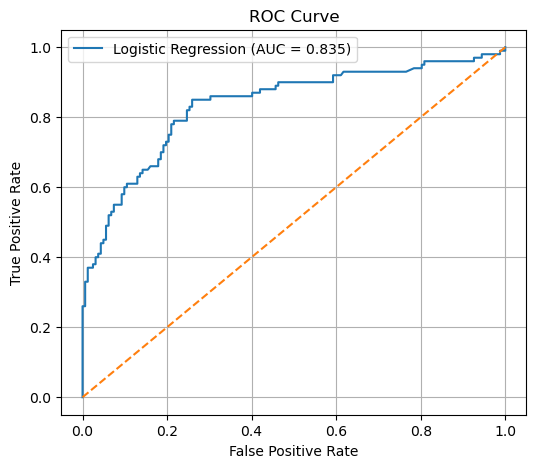

In [42]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # random classifier line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Interpretation of Model Performance

With an accuracy of roughly 70%, the Logistic Regression model correctly classified about 7 out of 10 passengers in the test set as either survivors or non-survivors.

Good discriminative performance is indicated by the ROC-AUC score of roughly 0.835. 
Random guessing would have an AUC of 0.5, whereas perfect classification would have a value near 1.0. 
As a result, an AUC of 0.835 indicates that the model can successfully differentiate between survivors and non-survivors.

The model outperforms random classification across a range of probability thresholds, as evidenced by the ROC curve, which is located well above the diagonal baseline.

The model performs well in terms of prediction overall, but feature engineering and hyperparameter tuning can still be used to enhance it.

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**